In [2]:
from src.utils import *
import pandas as pd
from Bio.PDB import MMCIFParser
import numpy as np

#PDB=3DAB source: https://onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1002%2Fanie.202213362&file=anie202213362-sup-0001-misc_information.pdf
MDMX="IQINQVRPKLPLLKILHAAGAQGEMFTVKEVMHYLGQYIMVKQLYDQQEQHMVYCGGDLLGELLGRQSFSVKDPSPLYDMLRKNLVTLAT"
db=pd.read_csv("./data/MDM2-MDMX_peptides.csv",sep=";")

db['MDMX (nM)'] = db['MDMX (nM)'].replace('Inactive', 10000).astype(int) # assuming that >10k = inactive
db = db.sort_values(by='MDMX (nM)')
db=db.reset_index(drop=True)
db['IC50_Rank'] = db['MDMX (nM)'].rank(method='min', ascending=True)

db

,Name,Sequence,MDM2 (nM),MDMX (nM),IC50_Rank
0,pMI,TSFAEYWNLLSP,20,40,1.0
1,PDIQ,ETFEHWWSQLLS,8,110,2.0
2,6W11L,LTFEHWWAQLLS,20,140,3.0
3,6W8S,LTFEHWWSQLTS,24,180,4.0
4,1E6W,ETFEHWWAQLTS,20,200,5.0
5,6W,LTFEHWWAQLTS,36,250,6.0
6,6W9S,LTFEHWWASLTS,125,500,7.0
7,PDI,LTFEHYWAQLTS,44,550,8.0
8,6W8S9S,LTFEHWWSSLTS,130,800,9.0
9,6N,LTFEHNWAQLTS,400,4000,10.0


### Identify Reference peptide

In [5]:
db['ESM2_initialLoss'] = db['Sequence'].apply(lambda peptide: compute_mlm_overall_withoutTheMaskedPos(MDMX, peptide, [], []))
# db['ESM2_initialLoss'] = db['Peptide_Experimental'].apply(lambda peptide: compute_mlm_overall(HTRA1, peptide, [], []))
db

,Name,Sequence,MDM2 (nM),MDMX (nM),IC50_Rank,ESM2_initialLoss
0,pMI,TSFAEYWNLLSP,20,40,1.0,19.341820
1,PDIQ,ETFEHWWSQLLS,8,110,2.0,19.224237
2,6W11L,LTFEHWWAQLLS,20,140,3.0,19.331839
3,6W8S,LTFEHWWSQLTS,24,180,4.0,19.354427
4,1E6W,ETFEHWWAQLTS,20,200,5.0,19.396828
5,6W,LTFEHWWAQLTS,36,250,6.0,19.412388
6,6W9S,LTFEHWWASLTS,125,500,7.0,19.411945
7,PDI,LTFEHYWAQLTS,44,550,8.0,19.558207
8,6W8S9S,LTFEHWWSSLTS,130,800,9.0,19.394419
9,6N,LTFEHNWAQLTS,400,4000,10.0,19.561356


In [6]:
min_index = db['ESM2_initialLoss'].idxmin()
reference_peptide = db.loc[min_index, 'Sequence']
reference_peptide

'ETFEHWWSQLLS'

### Get the binding affinity 

In [7]:
def compute_results(row):
    peptide = row['Sequence']
    MDMX_positions = [] 
    pep_positions = np.array(find_differences(reference_peptide, peptide)) 
    print(reference_peptide, peptide, pep_positions)
    # return compute_mlm_overall(HTRA1, reference_peptide, HTRA_positions, pep_positions)
    return compute_mlm_overall_withoutTheMaskedPos(MDMX, reference_peptide, MDMX_positions, pep_positions)

db['ESM2_ppi_score_overall'] = db.apply(compute_results, axis=1)
db

ETFEHWWSQLLS TSFAEYWNLLSP [ 0  1  3  4  5  7  8 10 11]
ETFEHWWSQLLS ETFEHWWSQLLS []
ETFEHWWSQLLS LTFEHWWAQLLS [0 7]
ETFEHWWSQLLS LTFEHWWSQLTS [ 0 10]
ETFEHWWSQLLS ETFEHWWAQLTS [ 7 10]
ETFEHWWSQLLS LTFEHWWAQLTS [ 0  7 10]
ETFEHWWSQLLS LTFEHWWASLTS [ 0  7  8 10]
ETFEHWWSQLLS LTFEHYWAQLTS [ 0  5  7 10]
ETFEHWWSQLLS LTFEHWWSSLTS [ 0  8 10]
ETFEHWWSQLLS LTFEHNWAQLTS [ 0  5  7 10]
ETFEHWWSQLLS ETFSDLWKLLPE [ 3  4  5  7  8 10 11]
ETFEHWWSQLLS LTFEHSWAQLTS [ 0  5  7 10]
ETFEHWWSQLLS ETFEHNWAQLTS [ 5  7 10]
ETFEHWWSQLLS LTFTHWWAQLTS [ 0  3  7 10]


,Name,Sequence,MDM2 (nM),MDMX (nM),IC50_Rank,ESM2_initialLoss,ESM2_ppi_score_overall
0,pMI,TSFAEYWNLLSP,20,40,1.0,19.341820,19.626831
1,PDIQ,ETFEHWWSQLLS,8,110,2.0,19.224237,19.224237
2,6W11L,LTFEHWWAQLLS,20,140,3.0,19.331839,19.298523
3,6W8S,LTFEHWWSQLTS,24,180,4.0,19.354427,19.343384
4,1E6W,ETFEHWWAQLTS,20,200,5.0,19.396828,19.414333
5,6W,LTFEHWWAQLTS,36,250,6.0,19.412388,19.372164
6,6W9S,LTFEHWWASLTS,125,500,7.0,19.411945,19.466839
7,PDI,LTFEHYWAQLTS,44,550,8.0,19.558207,19.535559
8,6W8S9S,LTFEHWWSSLTS,130,800,9.0,19.394419,19.428509
9,6N,LTFEHNWAQLTS,400,4000,10.0,19.561356,19.535559


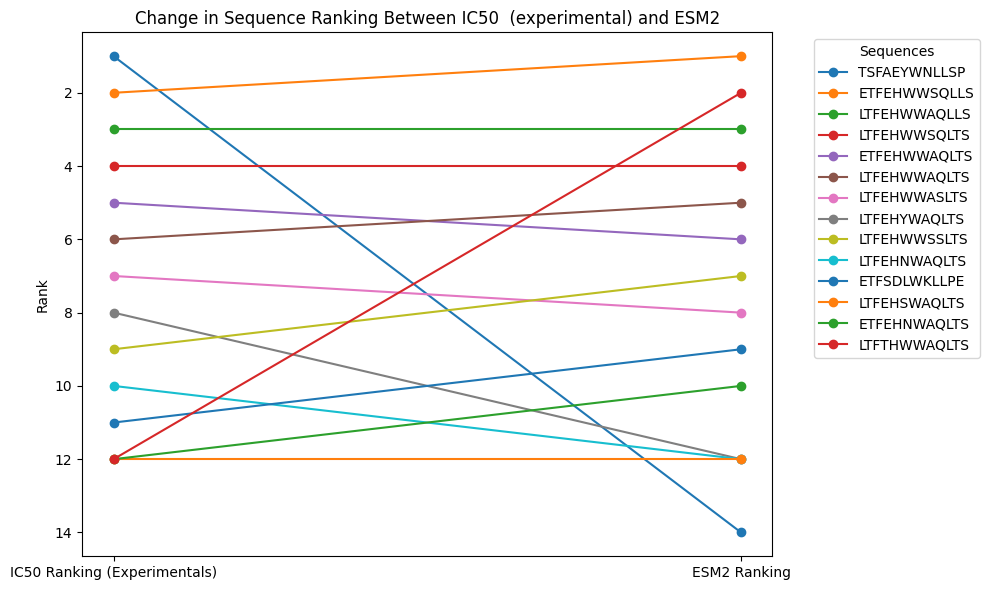

In [8]:
db['ESM2_Rank'] = db['ESM2_ppi_score_overall'].rank(ascending=True) 
# db['IC50_Rank'] = db['IC50_uM'].rank(ascending=True) 


plt.figure(figsize=(10, 6))
for _, row in db.iterrows():
    plt.plot([1, 2], [row['IC50_Rank'], row['ESM2_Rank']], '-o', label=row['Sequence'])

plt.xticks([1, 2], ['IC50 Ranking (Experimentals)', 'ESM2 Ranking'])
plt.gca().invert_yaxis()  # Invert y-axis so that lower ranks appear higher
plt.ylabel('Rank')
plt.title('Change in Sequence Ranking Between IC50  (experimental) and ESM2')
plt.legend(title="Sequences", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import ndcg_score
print("IC50",db["IC50_Rank"].values)
print("ESM2",db['ESM2_ppi_score_overall'].values)
ndcg_score([db["IC50_Rank"].values], [db["ESM2_ppi_score_overall"].values])

IC50 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 12. 12.]
ESM2 [19.62683105 19.22423744 19.29852295 19.34338379 19.41433334 19.37216377
 19.46683884 19.5355587  19.42850876 19.5355587  19.49421501 19.5355587
 19.49505997 19.26242256]


0.8125494862176819

In [11]:
ndcg_score([db["MDMX (nM)"].values], [db["ESM2_ppi_score_overall"].values])

0.6424483913186382

In [12]:
from scipy.stats import kendalltau
print(db['IC50_Rank'].values.astype(int))
print(db['ESM2_Rank'].values.astype(int))
# Calculate Kendall's Tau
tau, p_value = kendalltau(db['IC50_Rank'].values.astype(int), db['ESM2_Rank'].values.astype(int))

print(f"Kendall's Tau: {tau:.2f}")
print(f"P-value: {p_value:.4f}")

[ 1  2  3  4  5  6  7  8  9 10 11 12 12 12]
[14  1  3  4  6  5  8 12  7 12  9 12 10  2]
Kendall's Tau: 0.31
P-value: 0.1351
